# Experiment and path specification

In [2]:
# Specify the experiment for analysis
experiment='xppl2816'
runNumber = 74

# Set the installation and output path
import os
os.environ['INSTALLPATH']='/reg/neh/home4/mrware/TRXS'
os.environ['OUTPUTPATH']= '/reg/d/psdm/%s/%s/scratch' % (experiment[0:3],experiment)

# Import Libraries

In [3]:
# Magic iPython command to enable plotting
%matplotlib inline

# Load in the pythonBatchMagic library
import sys
sys.path.insert(0, os.environ['INSTALLPATH']+'/Libraries/pythonBatchMagic')
from pythonBatchMagic import *
# Determine current user
currentUser, error = unixCMD("echo $USER")
print(currentUser)
os.environ['RESULTSPATH']= ('/reg/d/psdm/%s/%s/res/%s' % (experiment[0:3],experiment,currentUser)).strip()
if not os.path.exists(os.environ['RESULTSPATH']):
    os.mkdir(os.environ['RESULTSPATH'])

mrware



OSError: [Errno 17] File exists: '/reg/d/psdm/xpp/xppl2816/res/mrware'

# Leveraging the batch queue to quickly grab point data

## Loading libraries

In [4]:
sys.path.insert(0, os.environ['INSTALLPATH']+'/Libraries/LCLS')
from LCLSdefault import *

sys.path.insert(0, os.environ['INSTALLPATH']+'/Libraries/mattsTools')
from picklez import *

# Load in the get data library
from dataAnalysis import *

# Load in the batch library for lcls
from lclsBatch import *

/reg/d/psdm/xpp/xppl2816/scratch/Memories/getCSPADcoords remembered!


## Grabbing point data across nodes

In [ ]:

detDict = {'opaint':{'name':'XppEnds_Ipm0','get-function': 'getIPM' },
           'xint3':{'name':'XppSb3_Ipm','get-function': 'getIPM' },
           'xpos3':{'name':'XppSb3_Ipm','get-function': 'getXPos' },
           'ypos3':{'name':'XppSb3_Ipm','get-function': 'getYPos' },
           'xint2':{'name':'XppSb2_Ipm','get-function': 'getIPM' },
           'xpos2':{'name':'XppSb2_Ipm','get-function': 'getXPos' },
           'ypos2':{'name':'XppSb2_Ipm','get-function': 'getYPos' },
           'xrayEnergy':{'name':'SIOC:SYS0:ML00:AO541','get-function': 'getXrayEnergy' },
          'stageencoder':{'name':'XppEndstation.0:USDUSB.0','get-function':'getStageEncoder'},
          'ttfltpos':{'name':'XPP:TIMETOOL:FLTPOS', 'get-function': 'getTTFltPos'},
          'ebeamcharge':{'name':'EBeam', 'get-function': 'getEbeamCharge'},
          'fltposfwhm':{'name':'XPP:TIMETOOL:FLTPOSFWHM', 'get-function': 'getFltPosFWHM'},
          'seconds':{'name':'seconds', 'get-function': 'getSeconds'},
          'nanoseconds':{'name':'nanonseconds', 'get-function': 'getNanoseconds'},
          'fiducials':{'name':'fiducials', 'get-function': 'getFiducials'},
          'cspadSum':{'name':'fiducials', 'get-function': 'getCSPADsum'},
          'cspadMedian':{'name':'fiducials', 'get-function': 'getCSPADmedian'}}


# Lookup={'EbeamCharge':None, 'XrayPulseEnergy':None, 'TTRefAmpl':None, 'TTFltPos':None,
#     'TTAmpl':None, 'TTFltPosFWHM':None, 'CSPAD':{'Integrated':None, 'Median':None}, 
#     'XrayIpm3':{'X':None, 'Y':None,'Sum':None},
#     'XrayIpm2':{'X':None, 'Y':None,'Sum':None}, 'OPAIpm':None}

batchThreads = batchPointDataGrabber( detDict, eventMax=1e5, experiment='xppl2816', runNumber=runNumber, rank=100 )
batchThreads.Queue = 'psanaq'
batchThreads.start()

## Check job status

In [ ]:
stdoutdata, stderrdata = bjobs()
print stdoutdata
print stderrdata

## Kill threads if they die

In [ ]:
# batchThreads.requestStop()
# time.sleep(5)
# bkill(killAll=True)

In [ ]:
batchThreads.status

## Drop empty array values

In [ ]:
pointData = batchThreads.detArrays

def dropEmpty(pointData):

    filledBin = (pointData['seconds'] > 0)

    for key in pointData.keys():
        pointData[key]=pointData[key][filledBin] 
        
    return pointData

pointData = dropEmpty(pointData)


## Save/Load point data

In [5]:
# save_obj( pointData, os.environ['RESULTSPATH']+'/pointData-run-%d' % runNumber )
pointData = load_obj( os.environ['RESULTSPATH']+'/pointData-run-%d' % runNumber )

/reg/d/psdm/xpp/xppl2816/res/mrware/pointData-run-74 remembered!


## Plot histogram of result

In [ ]:
detArrays = pointData

fig2, ax2 = plt.subplots(1, 1)
ax2.hist(detArrays['ebeamcharge'], bins=100,normed=False, alpha=0.5);

# Read in CSPAD via batch job

## Specify good idxs

In [7]:
goodIdx = runFilter( pointData , filterOn=['opaint' , 'xint3','xpos3','ypos3', 'xint2','xpos2','ypos2', 'xrayEnergy','ebeamcharge','fltposfwhm','cspadSum','cspadMedian'], maddevs=3 ).astype(bool)


## Now generate time delays

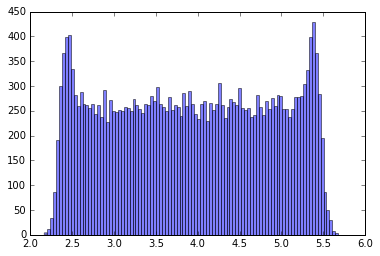

In [8]:
TTPoly = np.array([2.235e-7, -2.21e-3, 8.547e-1]) 

TTFltPos = pointData['ttfltpos']
TTCorrFltPos = TTPoly[0]*TTFltPos**2+TTPoly[1]*TTFltPos+TTPoly[2]

TTTime = TTCorrFltPos + pointData['stageencoder']

fig2, ax2 = plt.subplots(1, 1)
ax2.hist(TTTime[goodIdx], bins=100,normed=False, alpha=0.5);

# Read in timebinned CSPAD

In [ ]:

# timebins = np.arange( -1.5,1.5,.03 )
timebins = np.arange( 2.3,5.6,.03 ) # Run 74
dt = timebins[1]-timebins[0]
NT = timebins.size

tagList = []
for idx, t in enumerate(timebins):
    tIndex = (TTTime >= t-dt/2.)&(TTTime < t+dt/2.)
    allIndex = tIndex & goodIdx
    filteredSeconds = pointData['seconds'][allIndex]
    filteredNanoseconds = pointData['nanoseconds'][allIndex]
    filteredFiducials = pointData['fiducials'][allIndex]
    tagList.append( {'seconds':filteredSeconds, 'nanoseconds':filteredNanoseconds, 'fiducials':filteredFiducials} )

# batchThreads = batchCSPADGrabber (tagList, experiment=experiment, runNumber=runNumber)
batchThreads = batchCSPADMVGrabber (tagList, experiment=experiment, runNumber=runNumber)

batchThreads.Queue = 'psanaq'   
batchThreads.start()


In [ ]:
batchThreads.status
bjobs()

In [ ]:
batchThreads.requestStop()
bkill(killAll=True)

# Save / load resulting CSPAD

In [ ]:
batchThreads.gather()
CSPAD = batchThreads.CSPAD
variance = batchThreads.variance
counts = batchThreads.counts

In [6]:

# np.save(os.environ['RESULTSPATH']+'/timebins-run-%d' % runNumber ,timebins)
# np.save(os.environ['RESULTSPATH']+'/CSPAD-run-%d' % runNumber  , CSPAD)
# np.save(os.environ['RESULTSPATH']+'/variance-run-%d' %  runNumber , variance)
# np.save(os.environ['RESULTSPATH']+'/counts-run-%d' % runNumber  , counts)

timebins = np.load(os.environ['RESULTSPATH']+'/timebins-run-%d.npy' % runNumber )
CSPAD = np.load(os.environ['RESULTSPATH']+'/CSPAD-run-%d.npy' % runNumber)
variance = np.load(os.environ['RESULTSPATH']+'/variance-run-%d.npy' % runNumber)
counts = np.load(os.environ['RESULTSPATH']+'/counts-run-%d.npy' % runNumber)


# Plot CSPAD

58.2595789017


/reg/g/psdm/sw/conda/inst/miniconda2-prod-rhel7/envs/ana-1.3.9/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


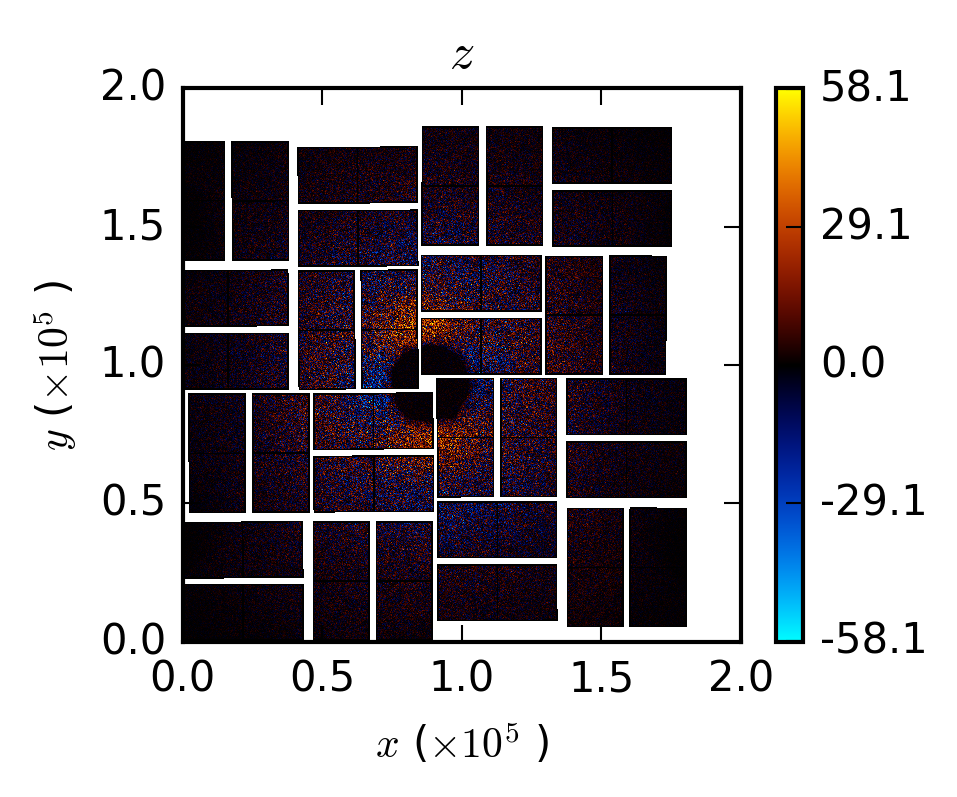

In [7]:
from IPython.display import clear_output
from plotStyles import *

def plotCSPAD( cspad , x , y, cspadMask=None, zLims = None, divergent=False ):
    figOpts = {'xLims':[0,2e5],'yLims':[0,2e5],'divergent':divergent, 'xIn':3, 'yIn':3*11.5/14.5}
    
    if cspadMask is not None:
        cspad=cspad*cspadMask
    
    if zLims is not None:
        figOpts['zLims'] = zLims
    
    for iTile in range(32):
        if iTile == 0:
            newFigure = True
        else:
            newFigure = False
        clear_output()
        colorPlot( x[iTile,:,:], y[iTile,:,:], cspad[iTile,:,:] , newFigure=newFigure, **figOpts);

x,y = CSPADgeometry()
cspadMask = createMask()

CSPADbinned = CSPAD
        
plotCSPAD( CSPADbinned[:,:,:,40]-CSPADbinned[:,:,:,30], x , y , cspadMask=cspadMask, divergent=True )

# ROI analysis

Ignoring undefined input variable ...
[]


<Container object of 3 artists>

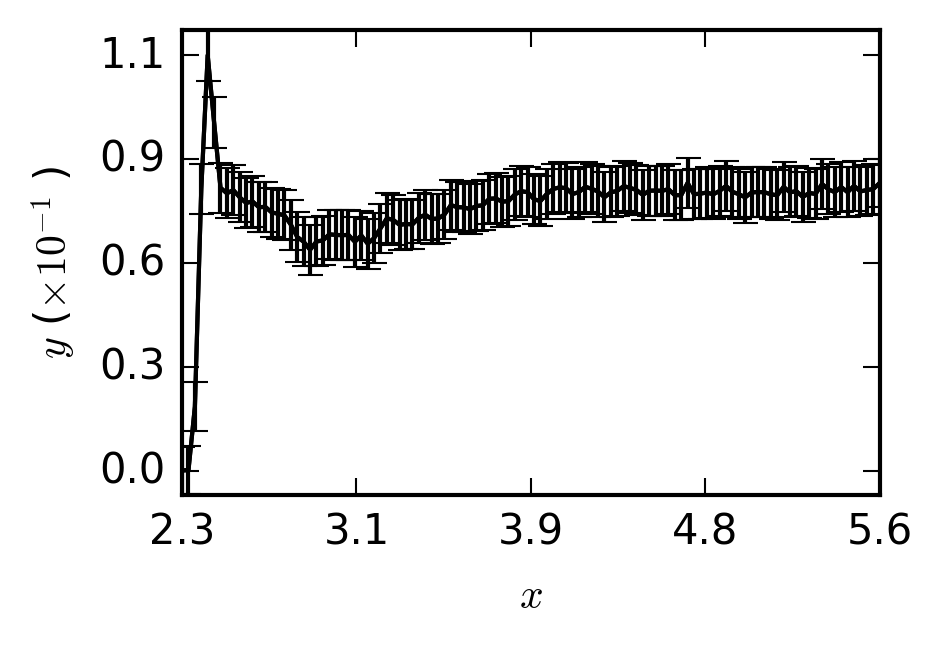

In [18]:
def roiSummed( x0, y0, dx, dy, x, y, image ):
    idx = ( x0 < x ) & ( (x0+dx) > x ) & ( y0 < y ) & ( (y0+dy) > y )
    return np.sum( image[idx , :] , 0 )

roi1 = roiSummed( 6e4, 11e4, 1e4, 1e4, x, y, CSPAD )
errroi1 = roiSummed( 6e4, 11e4, 1e4, 1e4, x, y, variance )
roi2 = roiSummed( 11e4, 6e4, 1e4, 1e4, x, y, CSPAD )
errroi2 = roiSummed( 11e4, 6e4, 1e4, 1e4, x, y, variance )

errorratio = 1/roi2*np.sqrt(errroi1)+roi1/roi2**2*np.sqrt(errroi2)

ratio = roi1/roi2
plotme = ratio[~np.isnan(ratio)]-ratio[~np.isnan(ratio)].min()
linePlot( timebins[~np.isnan(ratio)], plotme , newFigure = True)

plt.errorbar( timebins[~np.isnan(ratio)], plotme, yerr = errorratio[~np.isnan(ratio)] )

# Isotropic analysis

In [10]:
# Read in geometry and geometry measure dduring beamtime
XC,YC = 88097, 93696
X=np.array(x-XC)
Y=np.array(y-YC)
R=np.sqrt(np.power(X,2)+np.power(Y,2))
L=69e3

# Use two-theta to calculate Q
TwoTheta=np.arctan(R/L)
Q = 4*np.pi*np.sin(TwoTheta/2)/1.3874;
print np.max(Q)
PHID = np.arctan2(X,Y)#Y,X)
THETAD = TwoTheta;

# Form the Thomson correction factor
# THOMSON_CORRECTION = PHID; 
THOMSON_CORRECTION = ((np.sin(PHID)**2+np.cos(THETAD)**2.*np.cos(PHID)**2)); 

4.64444830766


# Radial integration

In [32]:
def radially_integrate(rgrid,Rmap,image,Mask=None):
    dr = rgrid[2]-rgrid[1]
    rsum=np.zeros_like(rgrid)
    
    for idx, r in enumerate(rgrid):
        rlower = r - dr/2.
        rupper = r + dr/2.

        if Mask is None:
            little_slice_r=((Rmap > rlower)&(Rmap < rupper))    
        else:
            little_slice_r=~((~((Rmap > rlower)&(Rmap < rupper))) | (Mask))

        normalizer=(np.nansum(np.abs(image[little_slice_r])>0))    
        if normalizer==0:
            rsum[idx]=np.nan
        else:
            rsum[idx] = np.nansum(image[little_slice_r]) / normalizer
    return rsum, normalizer

k0 = 4.5287 # 2pi/lambda

NQ = 200 # Must be divisible by 2
QMIN = 0.
QMAX = k0
qgrid = np.linspace(QMIN,QMAX,NQ)

NT = timebins.size
rad_int = np.zeros((NQ,NT))
rad_std = np.zeros((NQ,NT))

for t_idx in xrange(NT):
    rad_int[:,t_idx],nsum=radially_integrate(qgrid,Rmap=Q, image=CSPAD[:,:,:,t_idx]/THOMSON_CORRECTION, Mask=(cspadMask<1))
    var,nsum=radially_integrate(qgrid,Rmap=Q, image=variance[:,:,:,t_idx]/(THOMSON_CORRECTION**2), Mask=(cspadMask<1))
    
    rad_std[:,t_idx]=np.sqrt(var/nsum)

-1
(None, None)


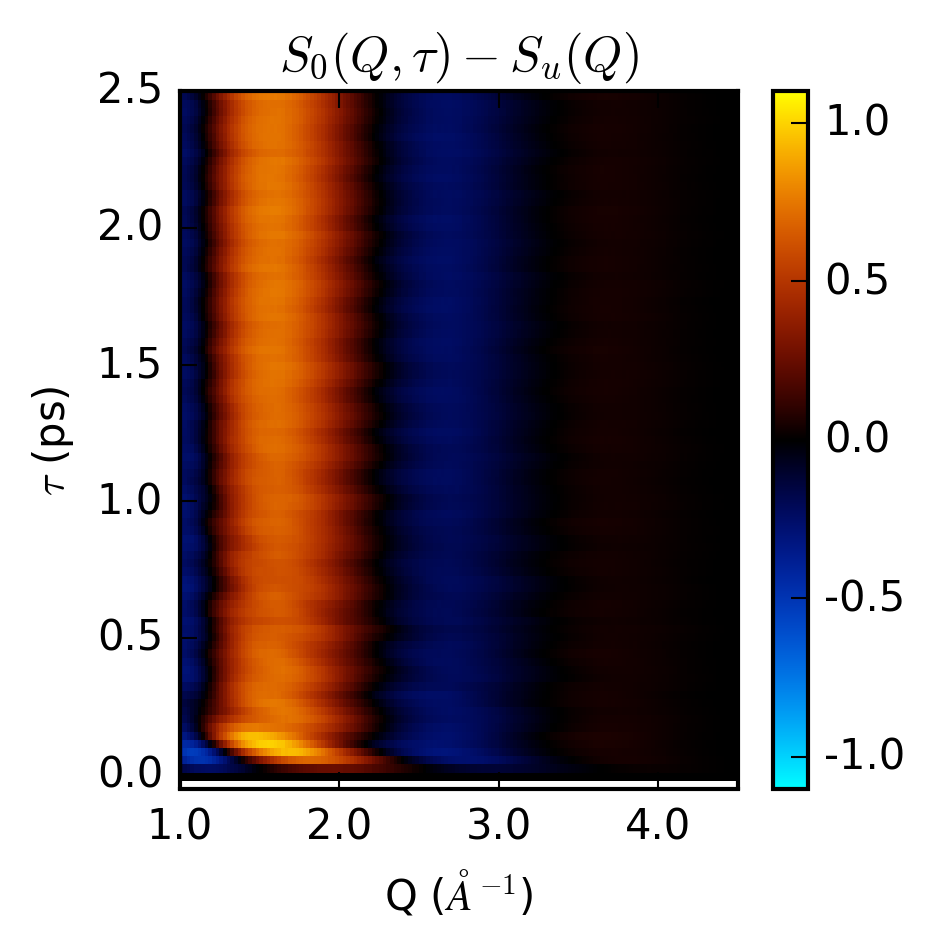

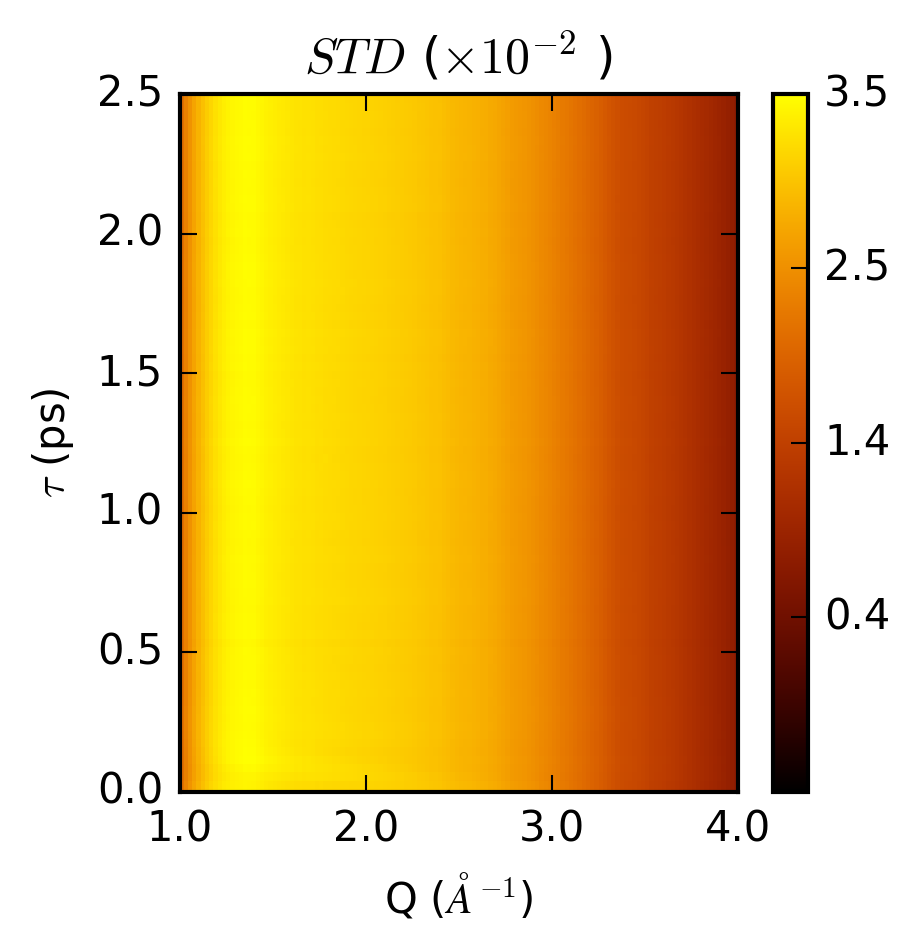

In [33]:
iT0=1
iQ0=20


TT,QQ = np.meshgrid(timebins[iT0:], qgrid[iQ0:])


plotme = (rad_int[iQ0:,iT0:])
plotme = plotme - plotme[:,0][:,np.newaxis]
plotme = plotme
scaleFac = plotme.flatten().max()
plotme = plotme / scaleFac

stdt0 = rad_std[iQ0:,iT0]


figOpts = {'xLims':[1,4.],'yLims':[0,2.5],'zLims':[-1,1], 'yLabel':r'$\tau$', 'yUnits':'ps', 'xLabel':'Q', 'xUnits':r'$\AA^{-1}$',
           'nxTicks':4, 'nyTicks':6, 'zLabel':r'$S_0(Q,\tau)-S_{u}(Q)$', 'divergent':True}

colorPlot(  qgrid[iQ0:],timebins[iT0:]-2.35,  (plotme).T , newFigure=True, **figOpts)

plt.ylim([-.05,2.5])
plt.xlim([1,4.5])


figOpts = {'xLims':[1,4.],'yLims':[0,2.5], 'yLabel':r'$\tau$', 'yUnits':'ps', 'xLabel':'Q', 'xUnits':r'$\AA^{-1}$',
           'nxTicks':4, 'nyTicks':6, 'zLabel':r'$STD$', 'divergent':False}
colorPlot( qgrid[iQ0:], timebins[iT0:]-2.35,   (( rad_std[iQ0:,iT0:]+stdt0[:,np.newaxis] )/scaleFac).T, newFigure=True, **figOpts)





# Legendre Analysis

# Mask the cspad images**

In [8]:

CB=counts
ValidIdx=np.squeeze(CB>50)
Validbins=CB[ValidIdx]
ValidT=timebins[ValidIdx]
CSPADV=CSPAD[:,:,:,ValidIdx]
CSPAD_VAR=variance[:,:,:,ValidIdx]
NT=Validbins.shape[0]
CSPAD_MASKED=np.zeros((32,185,388,NT))
CSPAD_VAR_MASKED=np.zeros((32,185,388,NT))
CSPAD_MSTD_MASKED=np.zeros((32,185,388,NT))

Mask = cspadMask<1

iPlaced=0
for itrT in xrange(NT):
    print((itrT,NT))
    CSPAD_IMAGE = CSPADV[:,:,:,itrT]
    CSPAD_IMAGE_VAR = CSPAD_VAR[:,:,:,itrT]
    CSPAD_IMAGE_MSTD = np.sqrt(CSPAD_IMAGE_VAR / float(Validbins[itrT]))
    
    CSPAD_IMAGE[Mask > 0] =  np.nan*CSPAD_IMAGE[Mask > 0];
    CSPAD_IMAGE_VAR[Mask > 0] =  np.nan*CSPAD_IMAGE_VAR[Mask > 0];
    CSPAD_IMAGE_MSTD[Mask > 0] =  np.nan*CSPAD_IMAGE_MSTD[Mask > 0];
    
    CSPAD_MASKED[:,:,:,itrT]= CSPAD_IMAGE
    CSPAD_VAR_MASKED[:,:,:,itrT]= CSPAD_IMAGE_VAR
    CSPAD_MSTD_MASKED[:,:,:,itrT]= CSPAD_IMAGE_MSTD

(0, 109)
(1, 109)
(2, 109)
(3, 109)
(4, 109)
(5, 109)
(6, 109)
(7, 109)
(8, 109)
(9, 109)
(10, 109)
(11, 109)
(12, 109)
(13, 109)
(14, 109)
(15, 109)
(16, 109)
(17, 109)
(18, 109)
(19, 109)
(20, 109)
(21, 109)
(22, 109)
(23, 109)
(24, 109)
(25, 109)
(26, 109)
(27, 109)
(28, 109)
(29, 109)
(30, 109)
(31, 109)
(32, 109)
(33, 109)
(34, 109)
(35, 109)
(36, 109)
(37, 109)
(38, 109)
(39, 109)
(40, 109)
(41, 109)
(42, 109)
(43, 109)
(44, 109)
(45, 109)
(46, 109)
(47, 109)
(48, 109)
(49, 109)
(50, 109)
(51, 109)
(52, 109)
(53, 109)
(54, 109)
(55, 109)
(56, 109)
(57, 109)
(58, 109)
(59, 109)
(60, 109)
(61, 109)
(62, 109)
(63, 109)
(64, 109)
(65, 109)
(66, 109)
(67, 109)
(68, 109)
(69, 109)
(70, 109)
(71, 109)
(72, 109)
(73, 109)
(74, 109)
(75, 109)
(76, 109)
(77, 109)
(78, 109)
(79, 109)
(80, 109)
(81, 109)
(82, 109)
(83, 109)
(84, 109)
(85, 109)
(86, 109)
(87, 109)
(88, 109)
(89, 109)
(90, 109)
(91, 109)
(92, 109)
(93, 109)
(94, 109)
(95, 109)
(96, 109)
(97, 109)
(98, 109)
(99, 109)
(100, 109)


## Rebinning from x,y to Qx,Qy to Q,theta

## x,y -> Qx,Qy

In [11]:

time0 = time.time()
# NQ = 100
NQ = 250 # Must be divisible by 2
QMIN = 0.
QMAX = 4.5
qGrid = np.linspace(QMIN,QMAX,NQ)
k0 = 4.5287 # 2pi/lambda
scaling_fac = np.sqrt(1.-Q**2 / (4.* k0**2)) #scaling for molecular space
angles_old = np.arctan2(Y, X)
angles = np.arccos(scaling_fac*np.cos(angles_old))
QX = Q * np.absolute(np.cos(angles))
QY = Q * np.absolute(np.sin(angles))

indX = np.round(float(NQ)*QX/QMAX)
indX = indX.flatten()

indY = np.round(float(NQ)*QY/QMAX)
indY = indY.flatten()

## THIS IS RIGHT BUT I FORGOT NANS!!!!
my_filter = (Mask < 1).flatten()

my_imgs = np.reshape(CSPAD_MASKED/np.repeat(np.expand_dims(THOMSON_CORRECTION,3),NT,axis=3),(388*185*32, NT))
my_vars = np.reshape(CSPAD_VAR_MASKED/np.repeat(np.expand_dims(THOMSON_CORRECTION**2,3),NT,axis=3),(388*185*32, NT))
my_mstds = np.reshape(CSPAD_MSTD_MASKED/np.repeat(np.expand_dims(THOMSON_CORRECTION,3),NT,axis=3),(388*185*32, NT))
imgQ = np.zeros((NQ,NQ,NT))
varQ = np.zeros((NQ,NQ,NT))
mstdQ = np.zeros((NQ,NQ,NT))
numQ = np.zeros((NQ,NQ))

print 'Rebinning the CSPAD in Qx-Qy space between ', QMIN, ' and ', QMAX, 'using NQ = ', NQ

for iX in xrange(NQ):
    print 'Iteration [%d], Time elapse %f' % (iX,time.time()-time0)
    for iY in xrange(NQ):
        inds = (indX == iX)*(indY == iY)*(my_filter.astype(bool))
        
        numQ[iX,iY] += inds.sum()
        
        red_img = sum(np.compress(inds,my_imgs,axis=0))
        red_mstd = sum(np.compress(inds,my_mstds,axis=0))
        red_var = sum(np.compress(inds,my_vars,axis=0))
        
        imgQ[iX,iY,:] += np.squeeze(imgQ[iX,iY,:]) + red_img
        mstdQ[iX,iY,:] += np.squeeze(mstdQ[iX,iY,:]) + red_mstd
        varQ[iX,iY,:] += np.squeeze(varQ[iX,iY,:]) + red_var





Rebinning the CSPAD in Qx-Qy space between  0.0  and  4.5 using NQ =  250
Iteration [0], Time elapse 6.375545
Iteration [1], Time elapse 8.286840
Iteration [2], Time elapse 10.210694
Iteration [3], Time elapse 12.152739
Iteration [4], Time elapse 14.079230
Iteration [5], Time elapse 16.059030
Iteration [6], Time elapse 17.984441
Iteration [7], Time elapse 19.897292
Iteration [8], Time elapse 21.814840
Iteration [9], Time elapse 23.731005
Iteration [10], Time elapse 25.648258
Iteration [11], Time elapse 27.601528
Iteration [12], Time elapse 29.516655
Iteration [13], Time elapse 31.439230
Iteration [14], Time elapse 33.366734
Iteration [15], Time elapse 35.298815
Iteration [16], Time elapse 37.248585
Iteration [17], Time elapse 39.190124
Iteration [18], Time elapse 41.125664
Iteration [19], Time elapse 43.060522
Iteration [20], Time elapse 44.995154
Iteration [21], Time elapse 46.929457
Iteration [22], Time elapse 48.871680
Iteration [23], Time elapse 50.805844
Iteration [24], Time elaps

1092.46781075


(-4.5, 4.5)

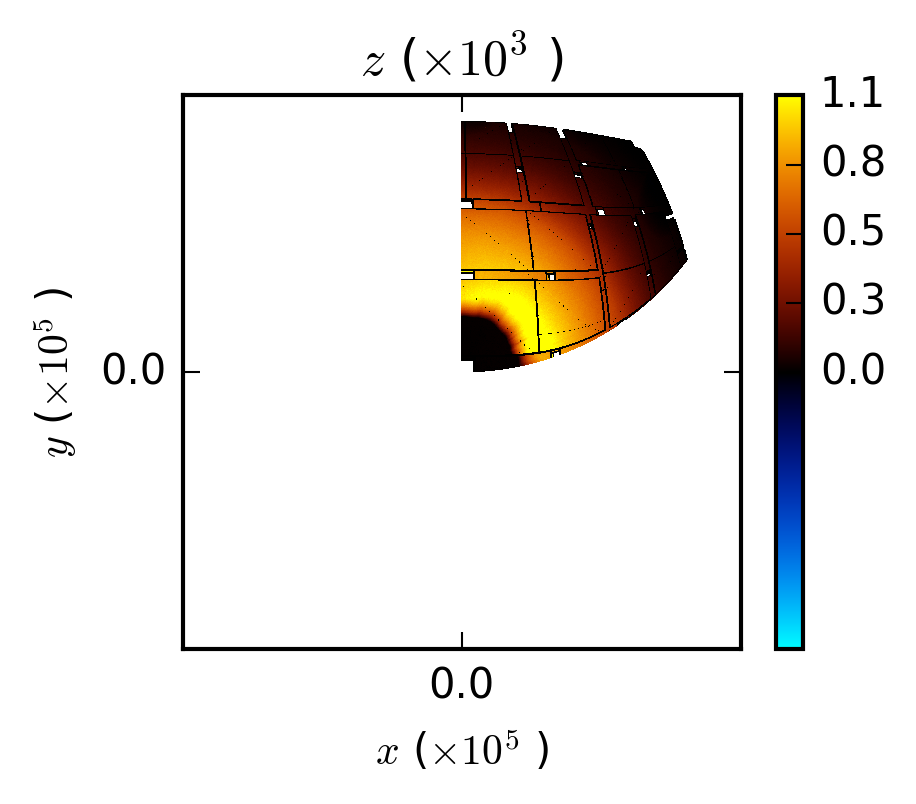

In [12]:
plotCSPAD( CSPADbinned[:,:,:,40], QX , QY , cspadMask=cspadMask, divergent=True )
plt.ylim([-QMAX,QMAX])
plt.xlim([-QMAX,QMAX])

## Plotting the difference signal in Qx-Qy

/reg/g/psdm/sw/conda/inst/miniconda2-prod-rhel7/envs/ana-1.3.9/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in divide


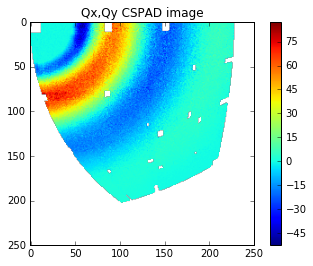

In [13]:
from matplotlib import cm
plt.close()
fig, ax = plt.subplots()

plotQ = (imgQ[:,:,30]-imgQ[:,:,1])/numQ;
# plotQ[np.isnan(plotQ)] = 0
# plotQ = numQ;

# #cax = ax.imshow(data, interpolation='nearest', cmap=cm.coolwarm)#, vmin=-200, vmax=200)
# cax = ax.pcolormesh(QX.flatten(),QY.flatten(),plotQ.flatten())#, interpolation='nearest', cmap=cm.coolwarm)#, vmin=-200, vmax=2
cax = ax.imshow(plotQ) #, vmin=0, vmax=1e2)#, interpolation='nearest', cmap=cm.coolwarm)#, vmin=-200, vmax=200)
ax.set_title('Qx,Qy CSPAD image')

cbar = fig.colorbar(cax)

plt.show()

## Plotting the mean standard deviation in Qx-Qy

/reg/g/psdm/sw/conda/inst/miniconda2-prod-rhel7/envs/ana-1.3.9/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in divide


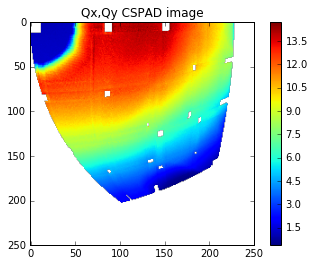

In [14]:
from matplotlib import cm
plt.close()
fig, ax = plt.subplots()

plotQ = (mstdQ[:,:,30])/numQ;
# plotQ = numQ;

# #cax = ax.imshow(data, interpolation='nearest', cmap=cm.coolwarm)#, vmin=-200, vmax=200)
# cax = ax.pcolormesh(QX.flatten(),QY.flatten(),plotQ.flatten())#, interpolation='nearest', cmap=cm.coolwarm)#, vmin=-200, vmax=2
cax = ax.imshow(plotQ)#, vmin=0, vmax=1e2)#, interpolation='nearest', cmap=cm.coolwarm)#, vmin=-200, vmax=200)
ax.set_title('Qx,Qy CSPAD image')

cbar = fig.colorbar(cax)

plt.show()

## Qx, Qy -> Q, theta

In [15]:
# Create the new `D Q and theta grids
NQ2 = NQ/2
# NQ2 = NQ/4
# NQ2 = NQ
qGrid2 = np.linspace(QMIN,QMAX,NQ2)
print 'Rebinning the CSPAD in Qx-Qy space between ', QMIN, ' and ', QMAX, 'using NQ = ', NQ2

NTHETAS = np.floor(np.pi*np.arange(NQ)/2)
NTHETA_MAX = NTHETAS[-1]

THETAS = np.zeros((NQ2,NTHETA_MAX))
for itr in xrange(NQ2):
    placeme=np.linspace(0,(np.pi)/2,NTHETAS[itr])
    THETAS[itr,0:len(placeme)]=placeme

# Initialize the storage arrays
imgQT=np.zeros((NQ2,NTHETA_MAX,NT))
mstdQT=np.zeros((NQ2,NTHETA_MAX,NT))
varQT=np.zeros((NQ2,NTHETA_MAX,NT))
numQT=np.zeros((NQ2,NTHETA_MAX))

# Find the original Q and angles
QX2, QY2=np.meshgrid(qGrid,qGrid)
Q2    = np.sqrt(QX2**2+QY2**2)
ANGLES=np.arctan2(QX2,QY2)

def find_nearest(array,value):
    try:
        idx = (np.abs(array-value)).argmin()
        return idx
    except ValueError:
        return 0

# Loop to place elements
time0=time.time()
for iQx in xrange(NQ):
    print 'Iteration [%d], Time elapse %f' % (iQx,time.time()-time0)
    for iQy in xrange(NQ):
        if numQ[iQx,iQy] > 0:
            idQ=find_nearest(qGrid2,Q2[iQx,iQy])
            idTH=find_nearest(np.squeeze(THETAS[idQ,0:NTHETAS[idQ]]),ANGLES[iQx,iQy])
            imgQT[idQ,idTH,:]+=imgQ[iQx,iQy,:]
            varQT[idQ,idTH,:]+=varQ[iQx,iQy,:]
            mstdQT[idQ,idTH,:]+=mstdQ[iQx,iQy,:]
            numQT[idQ,idTH]+=numQ[iQx,iQy]
 
print imgQT.shape

Rebinning the CSPAD in Qx-Qy space between  0.0  and  4.5 using NQ =  125
Iteration [0], Time elapse 0.000370
Iteration [1], Time elapse 0.017630
Iteration [2], Time elapse 0.020717
Iteration [3], Time elapse 0.023473
Iteration [4], Time elapse 0.026333
Iteration [5], Time elapse 0.029390
Iteration [6], Time elapse 0.032279
Iteration [7], Time elapse 0.035325
Iteration [8], Time elapse 0.037972
Iteration [9], Time elapse 0.040821
Iteration [10], Time elapse 0.043639
Iteration [11], Time elapse 0.046732
Iteration [12], Time elapse 0.049779
Iteration [13], Time elapse 0.052676
Iteration [14], Time elapse 0.055990
Iteration [15], Time elapse 0.059314
Iteration [16], Time elapse 0.062343
Iteration [17], Time elapse 0.065399
Iteration [18], Time elapse 0.068599
Iteration [19], Time elapse 0.071763
Iteration [20], Time elapse 0.074878
Iteration [21], Time elapse 0.077901
Iteration [22], Time elapse 0.081099
Iteration [23], Time elapse 0.084183
Iteration [24], Time elapse 0.087385
Iteration [

/reg/g/psdm/sw/conda/inst/miniconda2-prod-rhel7/envs/ana-1.3.9/lib/python2.7/site-packages/ipykernel/__main__.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/reg/g/psdm/sw/conda/inst/miniconda2-prod-rhel7/envs/ana-1.3.9/lib/python2.7/site-packages/ipykernel/__main__.py:17: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/reg/g/psdm/sw/conda/inst/miniconda2-prod-rhel7/envs/ana-1.3.9/lib/python2.7/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/reg/g/psdm/sw/conda/inst/miniconda2-prod-rhel7/envs/ana-1.3.9/lib/python2.7/site-packages/ipykernel/__main__.py:19: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/reg/g/psdm/sw/conda/inst/miniconda2-prod-rhel7/envs/ana-1.3.9/lib/python2.7

Iteration [55], Time elapse 0.185383
Iteration [56], Time elapse 0.190085
Iteration [57], Time elapse 0.194105
Iteration [58], Time elapse 0.197552
Iteration [59], Time elapse 0.200780
Iteration [60], Time elapse 0.204015
Iteration [61], Time elapse 0.207149
Iteration [62], Time elapse 0.210303
Iteration [63], Time elapse 0.213639
Iteration [64], Time elapse 0.217243
Iteration [65], Time elapse 0.220373
Iteration [66], Time elapse 0.223531
Iteration [67], Time elapse 0.226665
Iteration [68], Time elapse 0.230239
Iteration [69], Time elapse 0.233701
Iteration [70], Time elapse 0.236813
Iteration [71], Time elapse 0.239908
Iteration [72], Time elapse 0.243003
Iteration [73], Time elapse 0.245943
Iteration [74], Time elapse 0.249088
Iteration [75], Time elapse 0.251945
Iteration [76], Time elapse 0.254842
Iteration [77], Time elapse 0.258019
Iteration [78], Time elapse 0.261341
Iteration [79], Time elapse 0.264264
Iteration [80], Time elapse 0.267025
Iteration [81], Time elapse 0.270635
I

## Plot the image in Q, theta

/reg/g/psdm/sw/conda/inst/miniconda2-prod-rhel7/envs/ana-1.3.9/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in divide


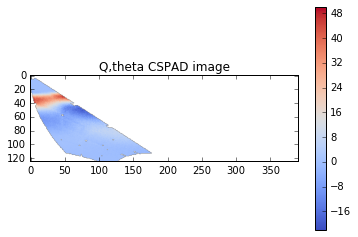

In [16]:
plt.close()
fig, ax = plt.subplots()

plotQ = (imgQT[:,:,-5]-np.mean(imgQT[:,:,2:6],axis=2))/numQT

cax = ax.imshow(plotQ, interpolation='bicubic', cmap=cm.coolwarm)
# clims=np.array([-1,1])*1e-1
# cax = ax.imshow(plotQ, vmin=clims[0], vmax=clims[1], interpolation='bicubic', cmap=cm.coolwarm)#, vmin=-200, vmax=200)

ax.set_title('Q,theta CSPAD image')

cbar = fig.colorbar(cax)

plt.show()

## Plot mean standard deviation in Q, theta

/reg/g/psdm/sw/conda/inst/miniconda2-prod-rhel7/envs/ana-1.3.9/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in divide


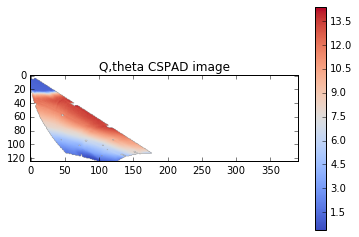

0


In [17]:
plt.close()
fig, ax = plt.subplots()

plotQ = (mstdQT[:,:,12])/numQT

cax = ax.imshow(plotQ, interpolation='bicubic', cmap=cm.coolwarm)
# clims=np.array([-1,1])*1e-1
# cax = ax.imshow(plotQ, vmin=clims[0], vmax=clims[1], interpolation='bicubic', cmap=cm.coolwarm)#, vmin=-200, vmax=200)

ax.set_title('Q,theta CSPAD image')

cbar = fig.colorbar(cax)

plt.show()

print np.sum(mstdQT < 0)

## Legendre Analysis

In [18]:
from scipy.special import legendre

def orthonormal_legendre_poly(n):
    return legendre(n)*np.sqrt((2.*n+1.)/2.)

def orthonormal_legendre_eval(n,x):
    p = orthonormal_legendre_poly(n)
    return p(x)

def generate_orthonormal_legendre_mat(lmax,x,even_only=True):
    if even_only:
        DL = 2
        NL = lmax/2 + 1
    else:
        DL = 1
        NL = lmax + 1
        
    P = np.zeros((NL,x.shape[0]))
    for idx, l in enumerate(xrange(0,lmax+DL,DL)):
        P[idx,:] = orthonormal_legendre_eval(l,x)
        
    return P

def chi_square(mean,mean_std,model,x):
    v0 = np.dot(x,model)
    vd = (v0 - mean) / mean_std
    return np.dot(vd,vd)

def chi_square_min(mean,mean_std,model):
    fx = np.dot(model, mean/mean_std**2)
    B  = np.dot(np.dot(model, np.diag(mean_std**-2)),model.transpose())
#     print B
    Bi = np.linalg.solve(B.T.dot(B), B.T)
#     Bi = np.linalg.inv(B)
    A  = np.dot(Bi,model)
    
    xmin = np.dot(A,mean/mean_std**2)
    
#     print mean_std
    mstd = np.dot(np.abs(A),mean_std)
#     print mstd
    
    cs   = chi_square(mean,mean_std,model,xmin)
    return {'xmin':xmin,'mstd':mstd, 'error_ratio':mstd/xmin,'cs':cs}
  
def generate_chi_square_map( lmax, NTHETAS, THETAS, imgQT, varQT, numQT, NT, NQ2, even_only=True ):
    lm      = np.zeros((lmax/2+1,NQ2,NT))
    lmstd   = np.zeros((lmax/2+1,NQ2,NT))
    cs_sum  = []
    cs0_sum = []
    NP = 0
    ND = 0

    for iT in xrange(0,NT):
        for iQ in xrange(10,NQ2):
            iThs = np.arange(0,NTHETAS[iQ]).astype(int)

            ValidIdxs = numQT[iQ,iThs] > 0
            iThs = iThs[ValidIdxs]

            P = generate_orthonormal_legendre_mat(lmax,THETAS[iQ,iThs])

            # print imgQT[iQ,iThs,iT]/numQT[iQ,iThs]
            # print mstdQT[iQ,iThs,iT]/numQT[iQ,iThs]

            means = imgQT[iQ,iThs,iT]/numQT[iQ,iThs]
            mstds = np.sqrt(varQT[iQ,iThs,iT]/numQT[iQ,iThs])
            reg=np.max(np.abs(means))

            means = means/reg
            mstds = mstds/reg
            

            model = chi_square_min(means , mstds, P)
#             model = chi_square_min(means , np.sqrt(np.abs(means)), P)
#             model = chi_square_min(means , np.ones_like(means), P)
            lm[:,iQ,iT] = model['xmin']*reg
            lmstd[:,iQ,iT] = model['mstd']*reg
            
            cs_sum.append(model['cs'])
            cs0_sum.append( chi_square(means,mstds,P,np.zeros_like(model['xmin'])) )
            
            if ~np.isnan(cs_sum[iT]):
                NP+=lmax/2+1
                ND+=means.shape[0]
            
#     return lm, lmstd, np.nanmean(cs_sum)/(lmax/2+1), np.nanmean(cs0_sum)/(lmax/2+1)
    return lm, lmstd, np.nansum(cs_sum), np.nansum(cs0_sum), ND, NP
    

lmax = 6
lm, lmstd, cs, cs0, ND, NP = generate_chi_square_map(lmax, NTHETAS, THETAS, imgQT, varQT, numQT, NT, NQ2, even_only=True )


    





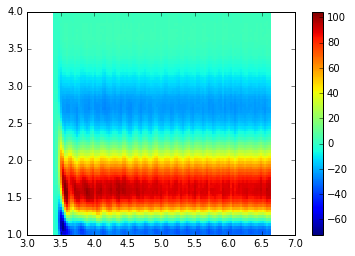

In [19]:
l=0
t_inds = np.arange(0,NT).astype(int)

plt.close()
fig, ax = plt.subplots()

clims = np.array([-1,1])

plotme = lm[l,:,t_inds].transpose()
t0 = plotme[:,0]
plotme = plotme - t0[:,np.newaxis]

cax = ax.pcolormesh(ValidT[t_inds]+1.1,qGrid2,plotme)#,vmin=clims[0],vmax=clims[1])

cbar = fig.colorbar(cax)
plt.ylim([1.,4.])
# plt.xlim([-.2,1.5])
plt.show()

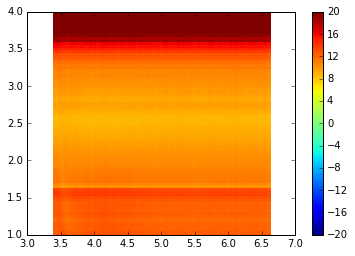

In [20]:
l=0
t_inds = np.arange(0,NT).astype(int)

plt.close()
fig, ax = plt.subplots()

clims = np.array([-1,1])*2e1

plotme = lmstd[l,:,t_inds].transpose()
t0 = plotme[:,0]
plotme = plotme + t0[:,np.newaxis]

cax = ax.pcolormesh(ValidT[t_inds]+1.1,qGrid2,plotme,vmin=clims[0],vmax=clims[1])

cbar = fig.colorbar(cax)
plt.ylim([1.,4.])
# plt.xlim([-.2,1.5])
plt.show()

In [21]:

import h5py

hf = h5py.File('phil-trans-data.h5', 'w')

hf.create_dataset('mean', data=lm)
hf.create_dataset('variance', data=lmstd)
hf.create_dataset('timebins', data=ValidT)
hf.create_dataset('Q', data=qGrid2)
hf.create_dataset('legendres', data=np.array([0,2,4,6]))

hf.close()


# Notes

## Settings for old outlier rejection

```python
Lookup={'EbeamCharge':None, 'XrayPulseEnergy':None, 'TTRefAmpl':None, 'TTFltPos':None,
    'TTAmpl':None, 'TTFltPosFWHM':None, 'CSPAD':{'Integrated':None, 'Median':None}, 
    'XrayIpm3':{'X':None, 'Y':None,'Sum':None},
    'XrayIpm2':{'X':None, 'Y':None,'Sum':None}, 'OPAIpm':None}

med  +/- 3 * mad
```